In [234]:

def fix_tie_up(X_binary):
    f, p = X_binary.shape
    X_binary = X_binary.copy()
    
    # change a bit in any duplicate rows
    for row_i in range(p):
        row_i_vec = X_binary[row_i]
        for row_j in range(p):
            row_j_vec = X_binary[row_j]
            if (row_i != row_j):
                if (row_i_vec == row_j_vec).all():
                    col_idx = np.random.randint(0, p)
                    X_binary[row_j, col_idx] = ~X_binary[row_j, col_idx]
    
    # change a bit in any duplicate columns
    for col_i in range(p):
        col_i_vec = X_binary[:, col_i]
        for col_j in range(p):
            col_j_vec = X_binary[:, col_j]
            if (col_i != col_j):
                if (col_i_vec == col_j_vec).all():
                    row_idx = np.random.randint(0, f)
                    X_binary[row_idx, col_j] = ~X_binary[row_idx, col_j]
    for i in range(p):
        if X_binary.sum(axis=0)[i] == 0:
            X_binary[np.random.randint(0, f), i] = True
        if X_binary.sum(axis=0)[i] == X_binary.shape[0]:
            X_binary[np.random.randint(0, f), i] = False
    # though not strictly necessary, also get rid of empty/full rows when possible
    for empty_row_idx in np.where(X_binary.sum(axis=1) == 0)[0]:
        colsums = X_binary.sum(axis=0)
        
        valid_cols = np.where(colsums < (f - 1))[0]
        if len(valid_cols) > 0:
            col_idx = np.random.choice(valid_cols)
            X_binary[empty_row_idx, col_idx] = True
    for full_row_idx in np.where(X_binary.sum(axis=1) == p)[0]:
        colsums = X_binary.sum(axis=0)
        
        valid_cols = np.where(colsums > 1)[0]
        if len(valid_cols) > 0:
            col_idx = np.random.choice(valid_cols)
            X_binary[full_row_idx, col_idx] = False
    return X_binary

def project_tie_up(X_T):
    X = X_T.T.copy()
    m = np.median(X[:])
    X_binary = X >= m
    for i in range(X_binary.shape[1]):
        if X_binary.sum(axis=0)[i] == 0:
            col_values = X[:, i]
            max_idx = np.argmax(col_values)
            
            X_binary[max_idx, i] = True
        if X_binary.sum(axis=0)[i] == X_binary.shape[0]:
            col_values = X[:, i]
            min_idx = np.argmin(col_values)
            X_binary[min_idx, i] = False
    return X_binary.T

def init_ident_rectangle(nrows, ncols, band=False):
    result = np.zeros((nrows, ncols), dtype=bool)
    max_val = max(nrows, ncols)
    for i in range(max_val):
        result[i % nrows, i % ncols] = True
        if band:
            result[i % nrows, (i + 1) % ncols] = True
            result[(i + 1) % nrows, i % ncols] = True
            
    return result

def init_threading_ramp(num_frames, num_threads, prob_uniform=0.5, prob_adjacent=0.1):
    assert num_threads > num_frames
    cols_per_segment = num_threads // num_frames
    result = np.zeros(num_threads, dtype=int)
    frame_indices = np.arange(num_frames)
    for i in range(num_threads):
        idx =  min(num_frames - 1, i // cols_per_segment)
        
        if np.random.rand() <= prob_uniform:
            result[i] = np.random.choice(frame_indices)
        elif np.random.rand() < prob_adjacent:
            result[i] = (idx + np.random.choice([-1, +1])) % num_frames
        else:
            result[i] = idx
    return result

def rand_tie_up(nrows, ncols, p=0.4):
    return np.random.rand(nrows, ncols) <= p

def rand_threading(num_frames, num_threads):
    return np.random.randint(0, num_frames, num_threads)
    
def rand_treadling(num_threads, num_pedals):
    return rand_threading(num_pedals, num_threads)


def proj_stochastic_cols(X):
    X_proj = X.copy()
    colmins = X.min(axis=0)
    assert len(colmins) == X.shape[1]
    for i in range(X.shape[1]):
        X_proj[:, i] -= colmins[i]
    colsums = X_proj.sum(axis=0)
    assert len(colsums) == X.shape[1]
    
    for i in range(X.shape[1]):
        X_proj[:, i] /= colsums[i]
    return X_proj

def proj_stochastic_rows(X):
    return proj_stochastic_cols(X.T).T
    
def proj_max_per_row(X):
    X_proj = np.zeros_like(X, dtype=bool)
    for i in range(X.shape[0]):
        max_idx = np.argmax(X[i])
        X_proj[i, max_idx] = True
    return X_proj

def proj_max_per_col(X):
    X_proj = np.zeros_like(X, dtype=bool)
    for i in range(X.shape[1]):
        max_idx = np.argmax(X[:, i])
        X_proj[max_idx, i] = True
    return X_proj

def normalize(X):
    X = X.copy()
    X -= X.min()
    X /= X.max()
    return X




def sample_row_indices(X_stochastic):
    nrows, ncols = X_stochastic.shape
    print(nrows, ncols)
    possible_cols = np.arange(ncols)
    result = np.zeros(nrows, dtype=int)
    for i in range(nrows):
        probs = X_stochastic[i].copy()
        probs -= probs.min()
        probs /= probs.sum()
        idx = np.random.choice(possible_cols, p=probs)
        result[i] = idx
    return result

def sample_col_indices(X_stochastic):
    result = sample_row_indices(X_stochastic.T)
    assert len(result) == n, "Expected length %d but got %d (image is %s)" % (n, len(result), X_true.shape)
    assert result.min() >= 0, "Expected min value %d but got %d" % (0, result.min())
    assert result.max() <= f, "Expected max value %d but got %d" % (n, result.max())
    return result

def sample_rows(X_stochastic):
    X_sample = np.zeros_like(X_stochastic, dtype=bool)
    indices = sample_row_indices(X_stochastic)
    for i in range(X_stochastic.shape[0]):
        X_sample[i, indices[i]] = True
    return X_sample
                 

def sample_cols(X_stochastic):
    return sample_rows(X_stochastic.T).T

# X_square = np.zeros(shape=(m, n), dtype=bool)
# X_square[2*m//9:7*m//9, 4*n//9:5*n//9] = True
# X_square[m//3:2*m//3, n//3:2*n//3] = True
# X_square[3*m//5:4*m//5, 2*n//7:5*n//7] = True
# rand_init = False

def treadling_matrix_from_indices(A):
    A_matrix = np.zeros((m, p), dtype=bool)
    for row_idx, pedal_idx in enumerate(A):
        A_matrix[row_idx, pedal_idx] = True
    return A_matrix

def threading_matrix_from_indices(C):
    C_matrix = np.zeros((f, n), dtype=bool)
    for col_idx, frame_idx in enumerate(C):
        C_matrix[frame_idx, col_idx] = True
    return C_matrix

def init_tie_up_least_squares(X_true, A, C):
    A_matrix = treadling_matrix_from_indices(A)
    C_matrix = threading_matrix_from_indices(C)
    return project_tie_up(np.linalg.pinv(A_matrix) @ X_true @ np.linalg.pinv(C_matrix))

def init_treadling_least_squares(X_true, B, C):
    C_matrix = threading_matrix_from_indices(C)
    A_approx = X_true @ np.linalg.pinv(C_matrix) @ np.linalg.pinv(B)
    assert A_approx.shape == (m, p), "Expected %s but got %s" % ((m, p), A_approx.shape)
    return sample_row_indices(A_approx)


def init_threading_least_squares(X_true, A, B):
    A_matrix = treadling_matrix_from_indices(A)
    C_approx = np.linalg.pinv(B) @ np.linalg.pinv(A_matrix) @ X_true
    assert C_approx.shape == (f, n), "Expected %s but got %s" % ((f, n), C_approx.shape)
    return sample_col_indices(C_approx)



def drawdown(A_idx, B, C_idx):
    assert (m,) == A_idx.shape
    assert (p, f) == B.shape
    assert (n,) == C_idx.shape
    assert A.max() < p, A.max()
    assert C.max() < f
   
    return B[A_idx[:, np.newaxis], C_idx]

X_approx = drawdown(A, B, C)

assert X_approx.shape == X_true.shape


def plot_matrices(A, B, C, X_true, filename=None):
    X_approx = drawdown(A, B, C)
    assert X_approx.shape == X_true.shape
    
    combined_width = 2 * n + 1 + p
    combined_height = m + 1 + f
    combined_image = np.zeros((combined_height, combined_width), dtype=bool)
    
    combined_image[f+1:m+f+1, :n] = X_true
    combined_image[f+1:m+f+1, n + 1: 2 * n + 1] = X_approx
    for row_idx, pedal_idx in enumerate(A):
        combined_image[f+1+row_idx, 2 * n + 1 + pedal_idx] = True
    for col_idx, frame_idx in enumerate(C):
        combined_image[frame_idx, n + 1 + col_idx] = True
    assert p, f == B.shape
    for pedal_idx in range(B.shape[0]):
        for frame_idx in range(B.shape[1]):
            combined_image[frame_idx, 2 * n + 1 + pedal_idx] = B[pedal_idx, frame_idx]
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,15))
    
    plt.imshow(combined_image, cmap="Greys", interpolation="nearest") 
    """
    plt.subplot(321)
    plt.imshow(C, cmap="Greys", interpolation="nearest")
  
    
    plt.subplot(322)
    plt.imshow(B.T, cmap='Greys',  interpolation='nearest')

    plt.subplot(323)
    plt.imshow(X_approx, cmap='Greys',  interpolation='nearest')

  
    plt.subplot(324)
    plt.imshow(A, cmap='Greys',  interpolation='nearest')
  
    plt.subplot(325)
    plt.imshow(X_true, cmap='Greys',  interpolation='nearest')
    """
    if filename:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()
    

    
def add_noise(X, scale=0.001):
    return normalize(X.copy() + np.random.randn(*X.shape) * scale)


def row_reconstruction_accuracy(X_original, row_idx, new_row):
    frac_true = X_original.mean()
    frac_false = 1.0 - frac_true
    weight_true = 1.0 / frac_true
    weight_false = 1.0 / frac_false
    sum_weights = (weight_true + weight_false)
    weight_true /= sum_weights
    weight_false /= sum_weights
    
    X_row = X_original[row_idx]
    same = (X_row == new_row)
    if (X_row.all()) or not (X_row.any()):
        return same.mean()
    else:
        return same[X_row].mean() * weight_true + same[~X_row].mean() * weight_false


def col_reconstruction_accuracy(X_original, row_idx, new_row):
    frac_true = X_original.mean()
    frac_false = 1.0 - frac_true
    X_row = X_original[row_idx]
    same = (X_row == new_row)
    if (X_row.all()) or not (X_row.any()):
        return same.mean()
    else:
        return same[X_row].mean() * frac_true + same[~X_row].mean() * frac_false
        

def reconstruction_accuracy(X_original, X_reconstruction):
    assert X_original.shape == X_reconstruction.shape, (X_original.shape, X_reconstruction.shape)
    same = (X_original == X_reconstruction)
    if same.sum() == 0:
        return 0.0
    elif X_original.all() or not (X_original.any()):
        return same.mean()
    else:
        return (same[X_original].mean() + same[~X_original].mean()) / 2


In [235]:


def improve_threading(X, A, B, C, n_cols=None):
    assert m == len(A)  
    assert n == len(C) 
    assert (p, f) == B.shape
    C = C.copy()
    col_order = np.arange(n)
    np.random.shuffle(col_order)
    if n_cols is None:
        n_cols  = n
    Xr = drawdown(A, B, C)
    same = (Xr == X)
    not_X = ~X
    n_true_in_X = X.sum()
    n_false_in_X = not_X.sum()
    frame_indices = np.arange(f)
    all_AB_cols = B[A[:, np.newaxis], frame_indices]
    
    for col_idx in col_order[:n_cols]:
        best_acc = 0
        best_idx = -1
        Xcol = X[:, col_idx]
        for frame_idx in frame_indices:
            same[:, col_idx] = (all_AB_cols[:, frame_idx] == Xcol)
            # Xr[:, col_idx] = all_AB_cols[:, frame_idx]
            n_true_same = np.count_nonzero(same[X])
            n_false_same = np.count_nonzero(same[not_X]) 
            acc = (n_true_same / n_true_in_X + n_false_same / n_false_in_X) / 2
            # acc = reconstruction_accuracy(X, Xr) 
            if acc > best_acc:
                best_acc = acc
                best_idx = frame_idx
        C[col_idx] = best_idx
        same[:, col_idx] = B[A, best_idx]
    return C
    
def improve_treadling(X, A, B, C, n_rows=None):
    A = A.copy()
    assert m == len(A)
    assert n == len(C)
    
    assert (p, f) == B.shape
    
    row_order = np.arange(m)
    np.random.shuffle(row_order)
    if n_rows is None:
        n_rows = m
    Xr = drawdown(A, B, C)
    same = (X == Xr)
    not_X = ~X
    n_true_in_X = X.sum()
    n_false_in_X = not_X.sum()
    
    pedal_indices = np.arange(p)
    all_BC_rows = B[pedal_indices[:, np.newaxis], C]
    for row_idx in row_order[:n_rows]:
        best_acc = 0
        best_idx = -1
        Xrow = X[row_idx]
        for pedal_idx in range(p):
            same[row_idx] = (Xrow == all_BC_rows[pedal_idx, :])
            n_true_same = np.count_nonzero(same[X])
            n_false_same = np.count_nonzero(same[not_X]) 
            acc = (n_true_same / n_true_in_X + n_false_same / n_false_in_X) / 2
            if acc > best_acc:
                best_acc = acc
                best_idx = pedal_idx
        assert best_idx >= 0
        A[row_idx] = best_idx
        Xr[row_idx] = B[best_idx][C]
    return A

def improve_tie_up(X, A, B, C, nsamples=None):
    p, f = B.shape
    
    if not nsamples:
        nelts = p * f
        nsamples = nelts # int(np.sqrt(nelts)) + 1
    not_X = ~X
    
    best_B = fix_tie_up(B.T.copy())
    best_reconstruction = drawdown(A, best_B.T, C)
    same = (X == best_reconstruction)
    best_accuracy = (same[X].mean() + same[not_X].mean()) / 2
    
    for _ in range(nsamples):
        candidate_B = best_B.copy()
        i, j = np.random.randint(0, f), np.random.randint(0, p)
        candidate_B[i, j] = ~candidate_B[i, j]
        candidate_B = fix_tie_up(candidate_B)
        Xr_new = drawdown(A, candidate_B.T, C)
        same = (X == Xr_new)
        acc = (same[X].mean() + same[not_X].mean()) / 2
        if acc > best_accuracy:
            best_accuracy = acc
            best_B = candidate_B
            best_reconstruction = Xr_new
    return best_B.T

Loaded /Users/iskander/Downloads/tate.jpg, with dimensions 400 x 400 (64.42% non-zero entries)


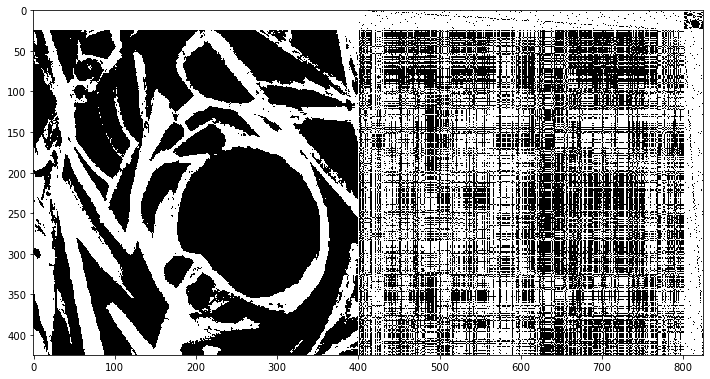

Iter #1, starting accuracy: 0.591
-- refining tie-up matrix B
-- refining treadling matrix A
-- refining threading matrix C
# updates in matrices: A=277, B=6, C=268


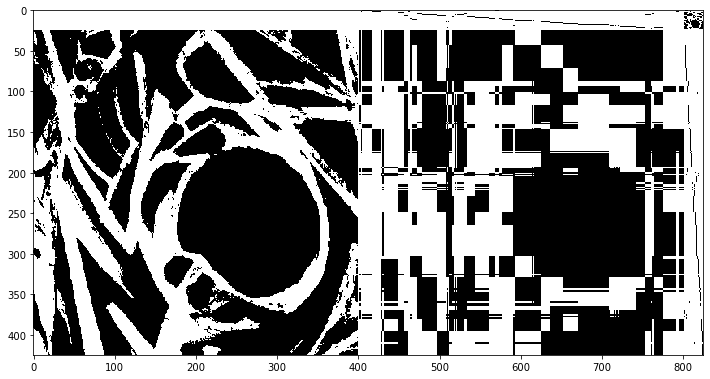

-- new accuracy at end of iter #1: 0.778
Iter #2, starting accuracy: 0.778
-- refining tie-up matrix B
-- refining treadling matrix A
-- refining threading matrix C
# updates in matrices: A=72, B=55, C=79


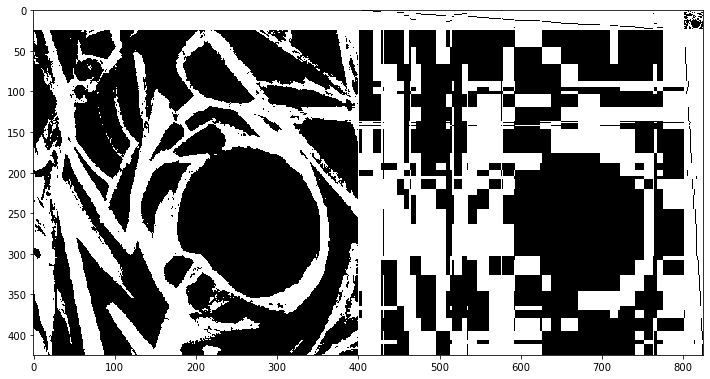

-- new accuracy at end of iter #2: 0.812
Iter #3, starting accuracy: 0.812
-- refining tie-up matrix B
-- refining treadling matrix A
-- refining threading matrix C
# updates in matrices: A=34, B=24, C=52


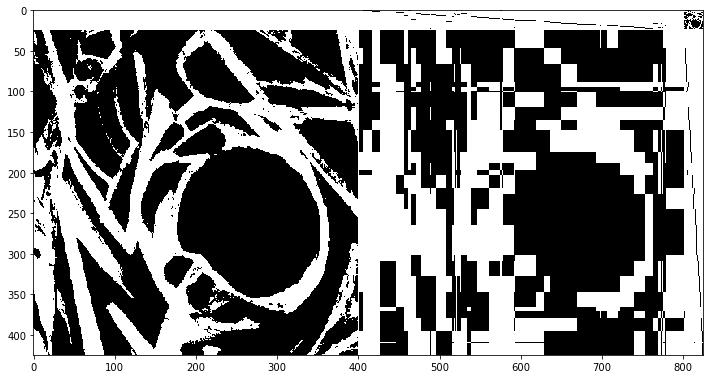

-- new accuracy at end of iter #3: 0.821
Iter #4, starting accuracy: 0.821
-- refining tie-up matrix B
-- refining treadling matrix A
-- refining threading matrix C
# updates in matrices: A=43, B=14, C=28


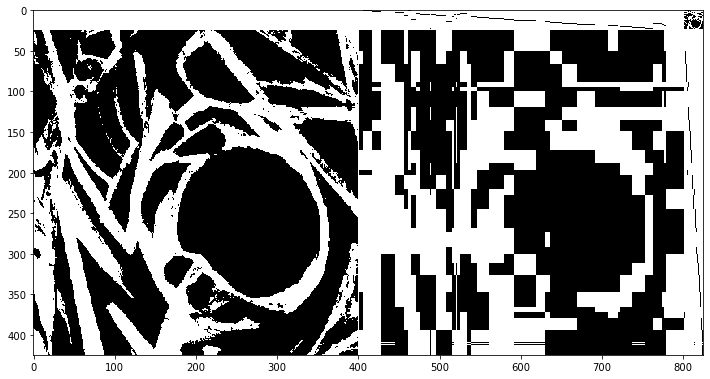

-- new accuracy at end of iter #4: 0.828
Iter #5, starting accuracy: 0.828
-- refining tie-up matrix B
-- refining treadling matrix A
-- refining threading matrix C
# updates in matrices: A=21, B=9, C=16


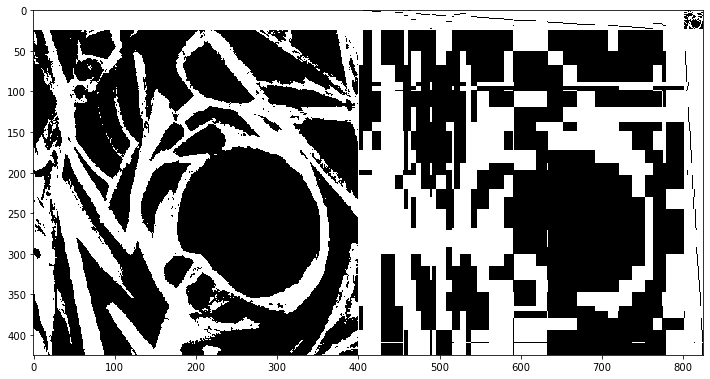

-- new accuracy at end of iter #5: 0.830
Iter #6, starting accuracy: 0.830
-- refining tie-up matrix B
-- refining treadling matrix A
-- refining threading matrix C
# updates in matrices: A=17, B=6, C=10


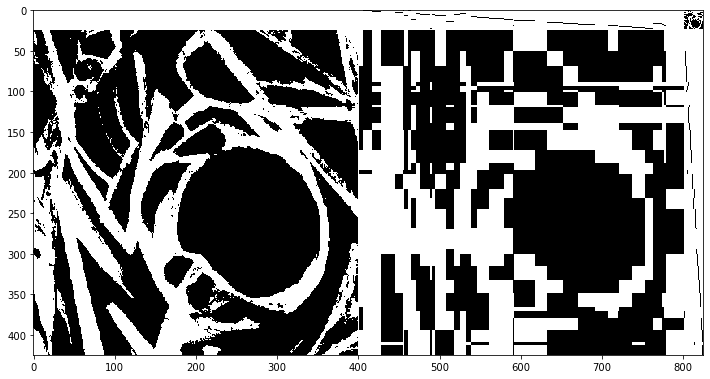

-- new accuracy at end of iter #6: 0.834
Iter #7, starting accuracy: 0.834
-- refining tie-up matrix B
-- refining treadling matrix A
-- refining threading matrix C
# updates in matrices: A=8, B=5, C=13


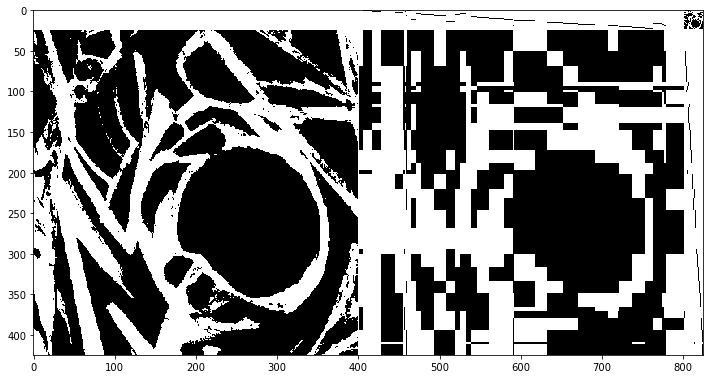

-- new accuracy at end of iter #7: 0.835
Iter #8, starting accuracy: 0.835
-- refining tie-up matrix B
-- refining treadling matrix A
-- refining threading matrix C
# updates in matrices: A=7, B=4, C=10


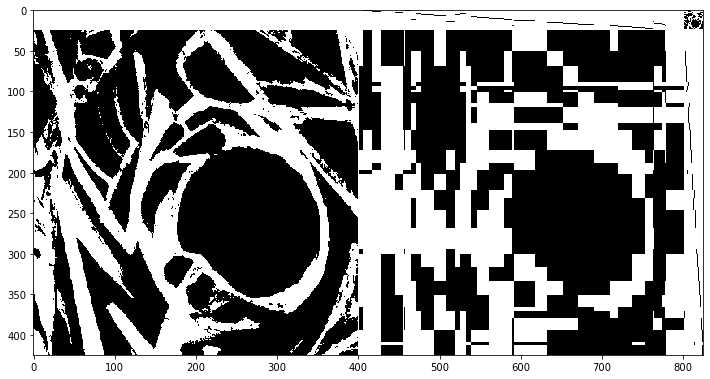

-- new accuracy at end of iter #8: 0.836
Iter #9, starting accuracy: 0.836
-- refining tie-up matrix B
-- refining treadling matrix A
-- refining threading matrix C
# updates in matrices: A=6, B=2, C=8


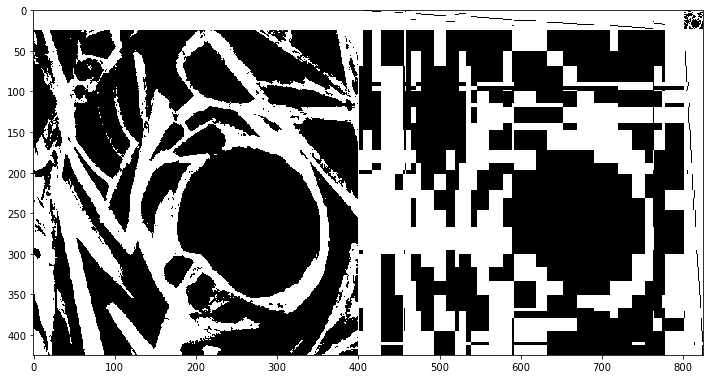

-- new accuracy at end of iter #9: 0.836
Iter #10, starting accuracy: 0.836
-- refining tie-up matrix B
-- refining treadling matrix A
-- refining threading matrix C
# updates in matrices: A=13, B=5, C=5


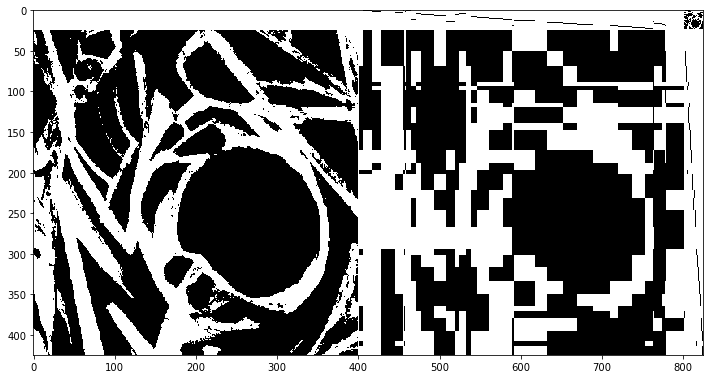

-- new accuracy at end of iter #10: 0.838
Iter #11, starting accuracy: 0.838
-- refining tie-up matrix B
-- refining treadling matrix A
-- refining threading matrix C
# updates in matrices: A=3, B=1, C=3


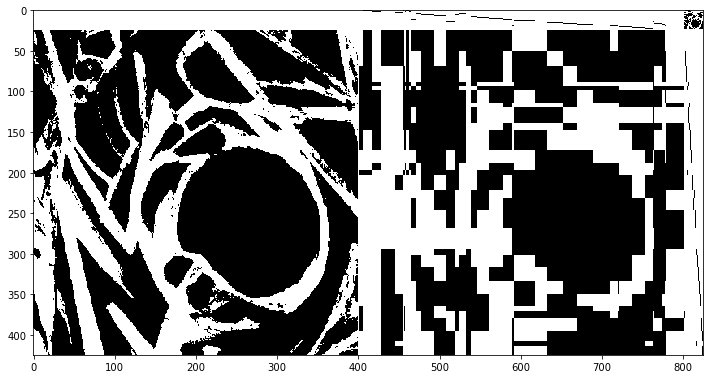

-- new accuracy at end of iter #11: 0.838
Iter #12, starting accuracy: 0.838
-- refining tie-up matrix B
-- refining treadling matrix A
-- refining threading matrix C
# updates in matrices: A=1, B=1, C=0


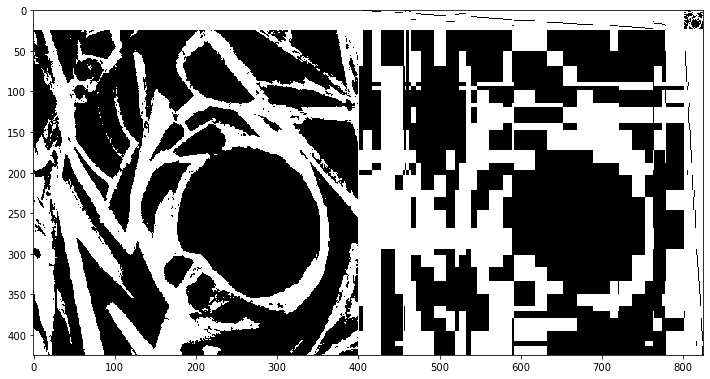

-- new accuracy at end of iter #12: 0.838
Iter #13, starting accuracy: 0.838
-- refining tie-up matrix B
-- refining treadling matrix A
-- refining threading matrix C


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (710, 379) to (720, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


# updates in matrices: A=0, B=0, C=0
-- Stopping early since matrices stopped changing


In [243]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# filename = "/Users/iskander/Downloads/stinkbug.webp"
# X_true = (mpimg.imread("/Users/iskander/Downloads/stinkbug.webp")[:, :, 1] > 120)[50:-50, 100:-100]

# filename = "/Users/iskander/Downloads/face.jpg"
# X_true = (mpimg.imread("/Users/iskander/Downloads/face.jpg")[:, :] > 120)[150:780, 150:600]
# X_true = (mpimg.imread("/Users/iskander/Downloads/trees.jpg")[:, :] > 120)
# X_true = (mpimg.imread("/Users/iskander/Downloads/m51.jpg")[:, :] > 120)[100:350, 180:430]
import matplotlib.colors

# img = mpimg.imread("/Users/iskander/Downloads/albers.jpg")
filename = "/Users/iskander/Downloads/tate.jpg"
img = mpimg.imread(filename)[200:600, 200:600]
# filename = "/Users/iskander/Downloads/krasner_blocks.jpeg"
# img = mpimg.imread(filename)[200:600, 200:600]

X_true = ((((img[:, :, 0].astype(float) + img[:, :, 1].astype(float) + img[:, :, 2].astype(float))) / 3)  > 100)
print("Loaded %s, with dimensions %d x %d (%0.2f%% non-zero entries)" % (
    filename, X_true.shape[0], X_true.shape[1], 100 * X_true.sum() / (X_true.shape[0] * X_true.shape[1])))

m, n  = X_true.shape
shafts = 24
f, p = shafts, shafts


A = init_threading_ramp(p, m)
C = init_threading_ramp(f, n)
B = init_tie_up_least_squares(X_true, A, C)


def optimize(X, A, B, C, max_iters=20):
    # B = init_tie_up_least_squares(X, A, C)
    
    plot_matrices(A, B, C, X)
    for iter_num in range(max_iters):
        print("Iter #%d, starting accuracy: %0.3f" % (iter_num + 1, reconstruction_accuracy(X, drawdown(A, B, C))))
        print("-- refining tie-up matrix B")
        B_new = improve_tie_up(X, A, B, C)
    
        print("-- refining treadling matrix A")
        A_new = improve_treadling(X, A, B_new, C)
        print("-- refining threading matrix C")
        C_new = improve_threading(X, A_new, B_new, C)
        
        n_diff_B = (B_new != B).sum() 
        n_diff_A = (A_new != A).sum()
        n_diff_C = (C_new != C).sum()
        print("# updates in matrices: A=%d, B=%d, C=%d" % (n_diff_A, n_diff_B, n_diff_C))
        
        # plt.imshow(C, interpolation='nearest', aspect='auto')
        if (n_diff_A + n_diff_B + n_diff_C) == 0:
            print("-- Stopping early since matrices stopped changing")
            break 
        A = A_new
        B = B_new
        C = C_new
        plot_matrices(A_new, B_new, C_new, X, filename="%d.png" % (iter_num + 1))
        print("-- new accuracy at end of iter #%d: %0.3f" % (iter_num + 1, reconstruction_accuracy(X, drawdown(A, B, C))))
    
    import imageio
    with imageio.get_writer('animation.gif', mode='I') as writer:
        for filename in ['%d.png' % i for i in range(1, iter_num + 1)]:
            image = imageio.imread(filename)
            writer.append_data(image)
    with imageio.get_writer('animation.mp4', mode='I', fps=24) as writer:
        for filename in ['%d.png' % i for i in range(1, iter_num + 1)]:
            image = imageio.imread(filename)
            writer.append_data(image)
            writer.append_data(image)
            writer.append_data(image)
            writer.append_data(image)
    return A, B, C

A_opt, B_opt, C_opt = optimize(X_true, A, B, C)

In [242]:
iter_num

NameError: name 'iter_num' is not defined

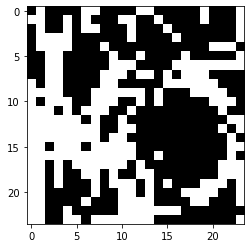

In [244]:
plt.imshow(B_opt, cmap="Greys", interpolation="nearest")

In [245]:
js = """let tie_up: boolean[] = bool_matrix_from_ints([\n"""
for i, row in enumerate(B_opt):
    js += "\t["
    for j, elt in enumerate(row):
        js += "1" if elt else "0"
        if j < len(row) - 1:
            js += ","
    js += "]"
    if i == B.T.shape[0] - 1:
        js += "])"
    else:
        js += ",\n"

In [247]:
print(js)

let tie_up: boolean[] = bool_matrix_from_ints([
	[1,0,1,1,1,1,0,0,1,1,1,1,0,0,1,1,1,1,1,0,1,1,1,0],
	[0,0,1,1,0,1,0,1,1,1,0,0,1,1,0,1,1,1,1,0,1,1,1,0],
	[1,0,1,1,0,1,0,0,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,0],
	[1,0,0,0,0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,0],
	[1,0,0,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1],
	[1,1,0,0,1,1,1,1,1,0,1,1,0,1,1,1,1,0,1,1,1,1,1,0],
	[1,1,0,0,1,1,1,1,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0],
	[1,1,0,0,1,1,1,1,0,0,0,1,0,0,1,0,1,0,0,0,1,1,1,1],
	[0,1,0,0,1,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,1,1,1],
	[0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,1,1],
	[0,1,0,0,0,1,1,0,0,0,1,1,0,1,0,1,1,1,1,1,0,0,0,1],
	[0,0,0,1,0,1,0,0,0,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1],
	[0,0,0,0,0,0,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0],
	[0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,0,1,0],
	[0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0,1],
	[0,0,1,0,0,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0],
	[0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,1,1,0,1],
	[0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,0,0,0],
	[0,0,1,0,1,1,0,

In [248]:
f


24